In [178]:
# Copyright (C) 2018 Daniel Page <csdsp@bristol.ac.uk>
#
# Use of this source code is restricted per the CC BY-NC-ND license, a copy of
# which can be found via http://creativecommons.org (and should be included as
# LICENSE.txt within the associated archive or repository).

from numpy import *
import numpy as np
import struct
import sys
import matplotlib.pyplot as plt
from Crypto.Cipher import AES

In [179]:
########################## CONSTANTS DEFINITION ################################

# Inverse S-BOX Table
inv_s = np.array([
0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D
], uint8)

sbox = np.array([
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16])

# Byte Hamming Weight Table
HW = np.array([
0,1,1,2,1,2,2,3,1,2,2,3,2,3,3,4,
1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,
1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,
2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,
2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,
1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,
2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,
2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,
3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,
4,5,5,6,5,6,6,7,5,6,6,7,6,7,7,8
], uint8)

#key to current plaintext- count rows then columns!
shiftkey = np.array([0,14,11,8,5,2,15,12,9,6,3,16,13,10,7,4], uint8)

In [180]:
# Load  a trace data set from an on-disk file.
#
# \param[in] f the filename to load  trace data set from
# \return    t the number of traces
# \return    s the number of samples in each trace
# \return    M a t-by-16 matrix of AES-128  plaintexts
# \return    C a t-by-16 matrix of AES-128 ciphertexts
# \return    T a t-by-s  matrix of samples, i.e., the traces
loaded_traces_num = 50


def traces_ld(f):
    fd = open(f, "rb")

    def rd(x):
        (r, ) = struct.unpack(x, fd.read(struct.calcsize(x)))
        return r

    t = rd('<I')
    s = rd('<I')

    M = numpy.zeros((t, 16), dtype=numpy.uint8)
    C = numpy.zeros((t, 16), dtype=numpy.uint8)

    for i in range(t):
        for j in range(16):
            M[i, j] = rd('<B')

    print("M plaintexts load finish", M.shape)

    for i in range(t):
        for j in range(16):
            C[i, j] = rd('<B')

    print("C ciphertexts load finish", C.shape)

    t = loaded_traces_num
    T = numpy.zeros((t,  s), dtype=numpy.int16)
    
    for i in range(t):
        for j in range(s):
            T[i, j] = rd('<h')

    print("T traces samples load finish")

    fd.close()

    return t, s, M, C, T

# Store a trace data set into an on-disk file.
#
# \param[in] f the filename to store trace data set into
# \param[in] t the number of traces
# \param[in] s the number of samples in each trace
# \param[in] M a t-by-16 matrix of AES-128  plaintexts
# \param[in] C a t-by-16 matrix of AES-128 ciphertexts
# \param[in] T a t-by-s  matrix of samples, i.e., the traces


def traces_st(f, t, s, M, C, T):
    fd = open(f, "wb")

    def wr(x, y):
        fd.write(struct.pack(x, y))

    wr('<I', t)
    wr('<I', s)

    for i in range(t):
        for j in range(16):
            wr('<B', M[i, j])

    for i in range(t):
        for j in range(16):
            wr('<B', C[i, j])

    for i in range(t):
        for j in range(s):
            wr('<h', T[i, j])

    fd.close()


In [181]:
def intermediate(plaintext, keyguess):
    return sbox[plaintext ^ keyguess]

In [205]:
# Attack implementation, as invoked from main after checking command line
# arguments.
#
# \param[in] argc number of command line arguments
# \param[in] argv           command line arguments

def attack(argc, argv):
    np.seterr(divide='ignore', invalid='ignore')
    loaded_traces_num = 200
    t, s, M, C, T = traces_ld(argv[1])
    print("the number of traces %s" % t)
    print("the number of samples in each traces %s" % s)

    numtraces = np.shape(T)[0]
    #     numpoint = np.shape(T)[1] // 2
    numpoint = 8000
    bestguess = np.zeros(16, dtype=np.uint8)

    print("the number of samples used %s" % numpoint)
    b = 1
    for bnum in range(16):
        maxcpa = [0]*256
        hyp = np.zeros((numtraces, 256))
        key_trace = np.zeros((256,numpoint))
        for kguess in range(0, 256):        
            for tnum in range(0, numtraces):
                hyp[tnum][kguess] = HW[intermediate(M[tnum][bnum], kguess)]

        chunksize = 50
        chunks = numpoint // 50
        for i in range(0, 256):
            for j in range(0, chunks):
                cmatrix = np.corrcoef(hyp[:,i], T[:, j*chunksize:(j+1)*chunksize].T )
                key_trace[i, j*chunksize:(j+1)*chunksize] = cmatrix[0,1:chunksize+1]       
            maxcpa[i] = max(abs(key_trace[i]))
        bestguess[bnum] = np.argmax(maxcpa)
        print("%02x "% bestguess[bnum], end='')
        print("%2f"% max(maxcpa))

    print("\nkey_trace generated")
    for b in bestguess: 
            print("%02x "%b, end='')
    return key_trace, bestguess

In [206]:
loaded_traces_num = 200
numpoint = 7500
key_trace, guessKey = attack(2, [" ", "traces.dat"])

M plaintexts load finish (1000, 16)
C ciphertexts load finish (1000, 16)
T traces samples load finish
the number of traces 200
the number of samples in each traces 112392
the number of samples used 8000
d3 0.384292
85 0.690995
33 0.604432
46 0.714572
02 0.755468
8b 0.774071
6e 0.748288
24 0.701674
86 0.741509
62 0.730402
e9 0.786994
95 0.730307
ab 0.758618
68 0.678338
7e 0.708946
25 0.693083

key_trace generated
d3 85 33 46 02 8b 6e 24 86 62 e9 95 ab 68 7e 25 

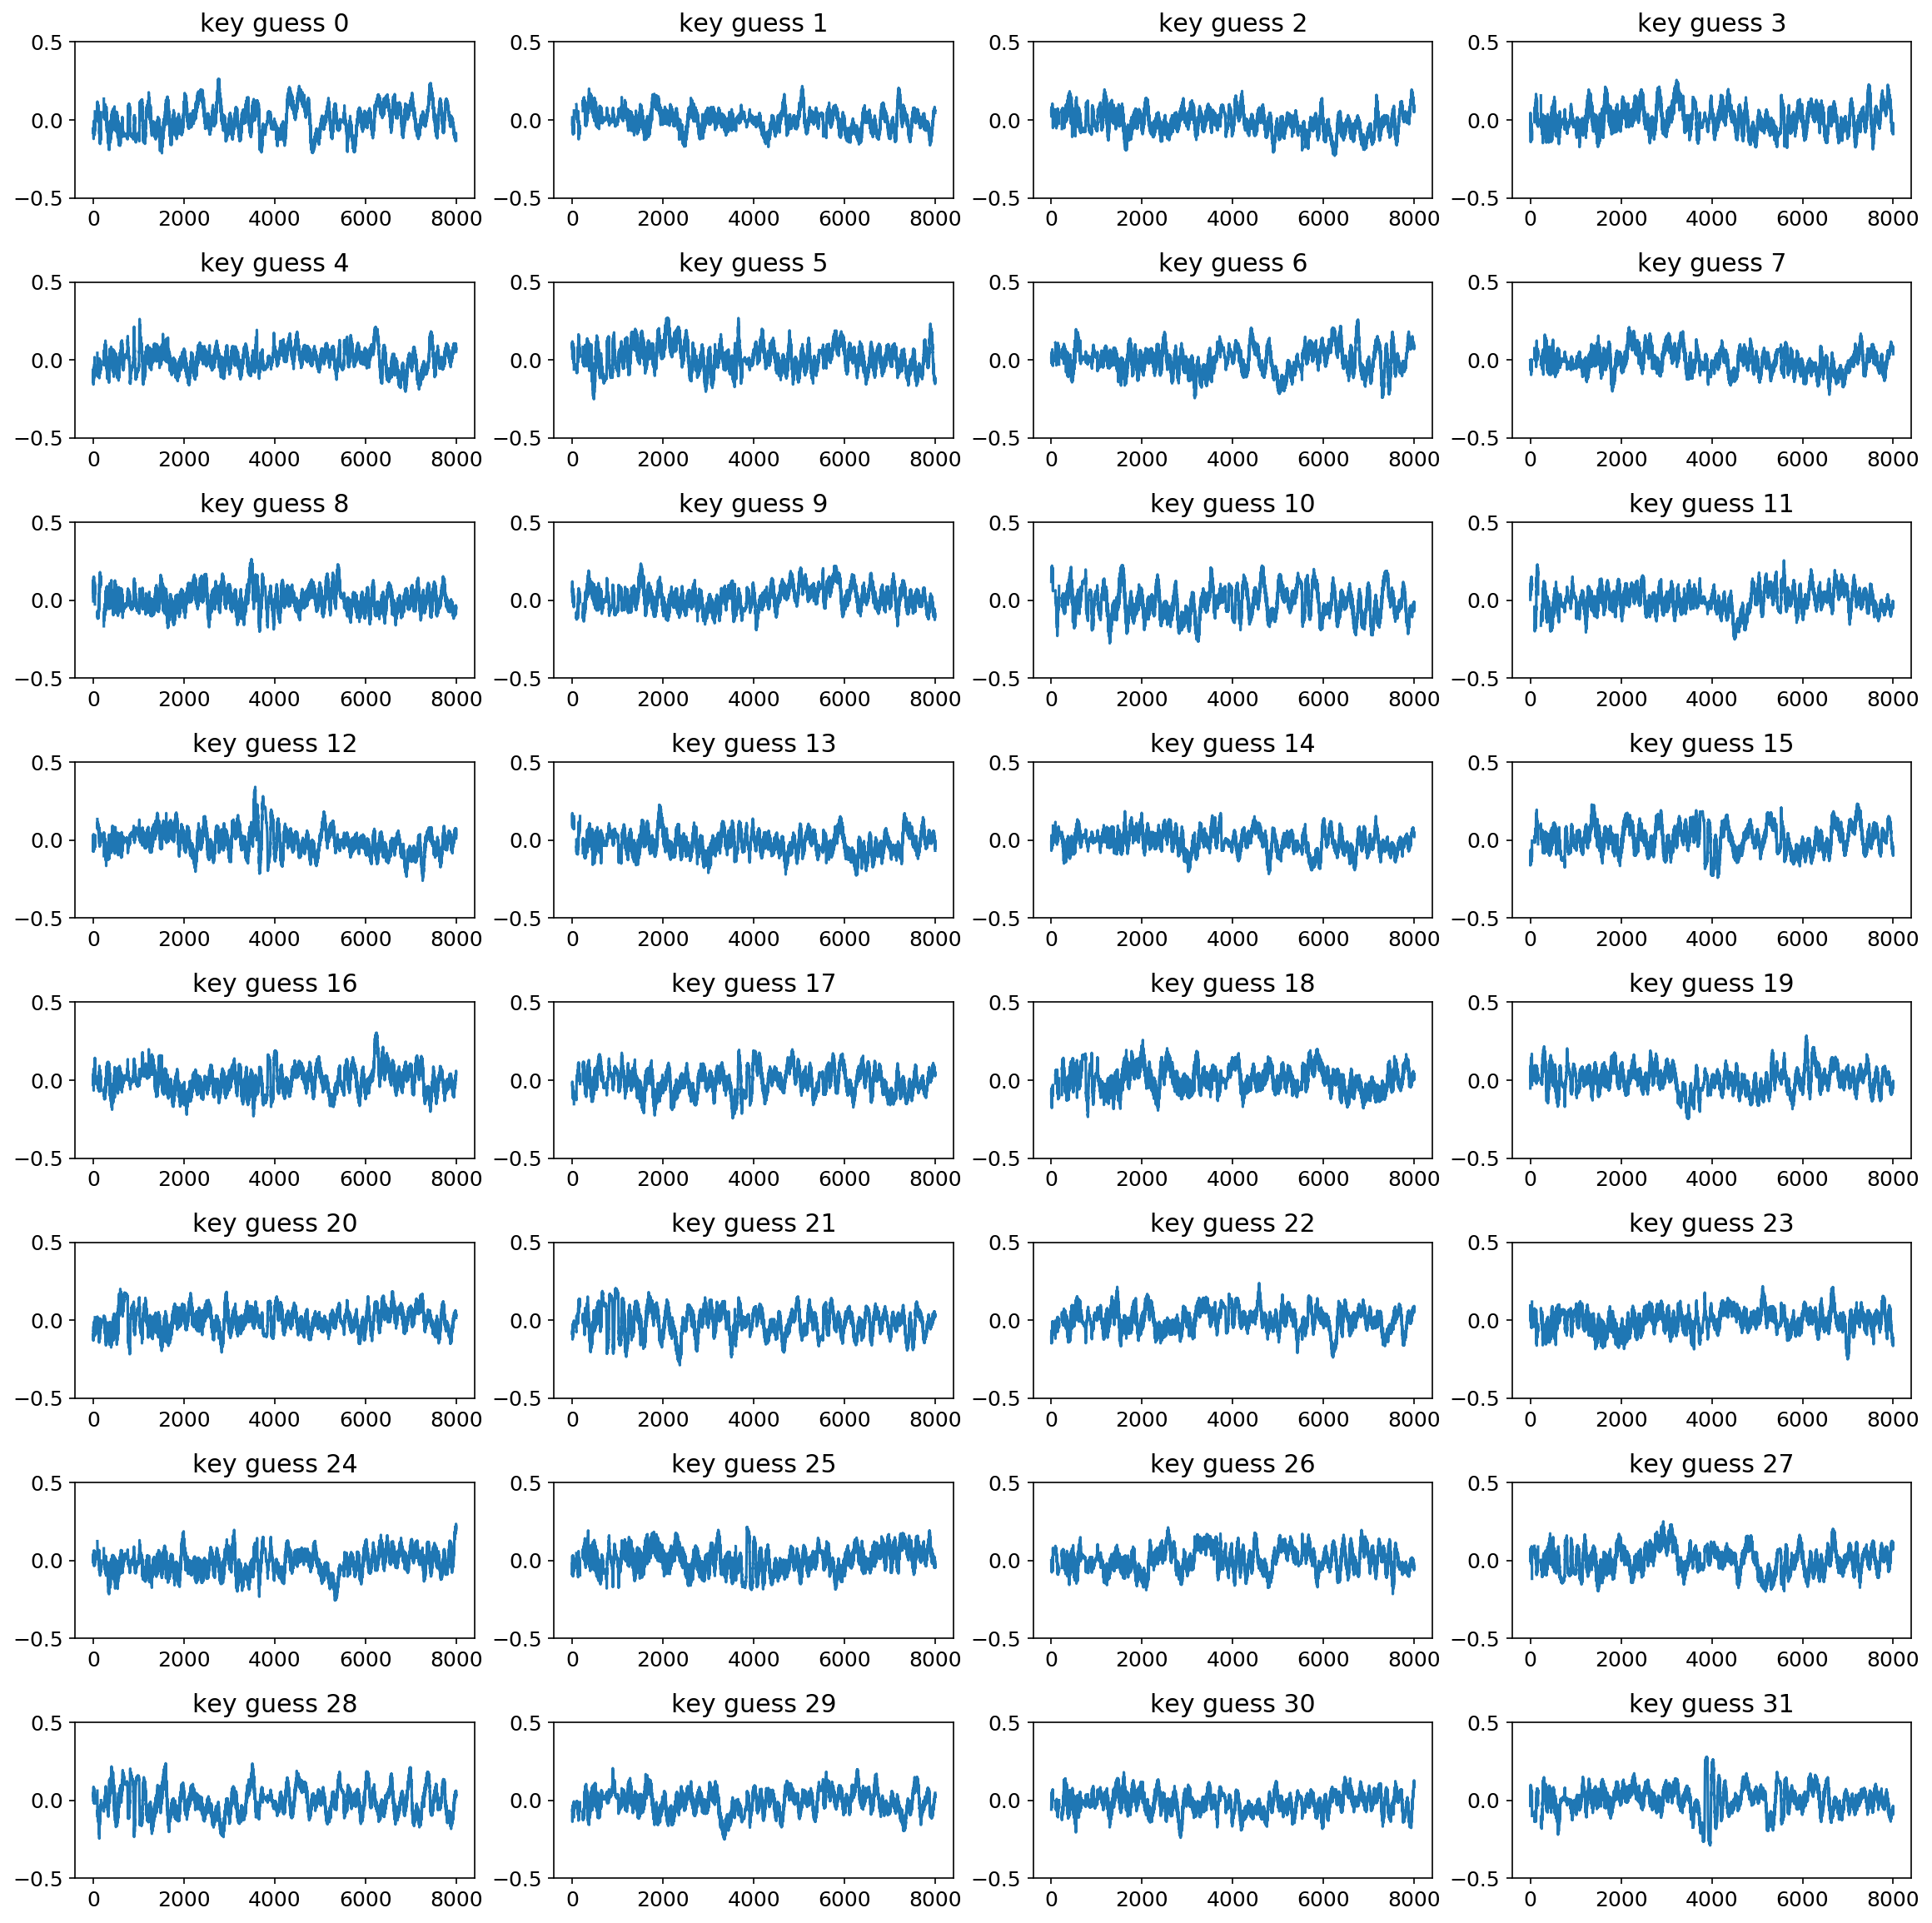

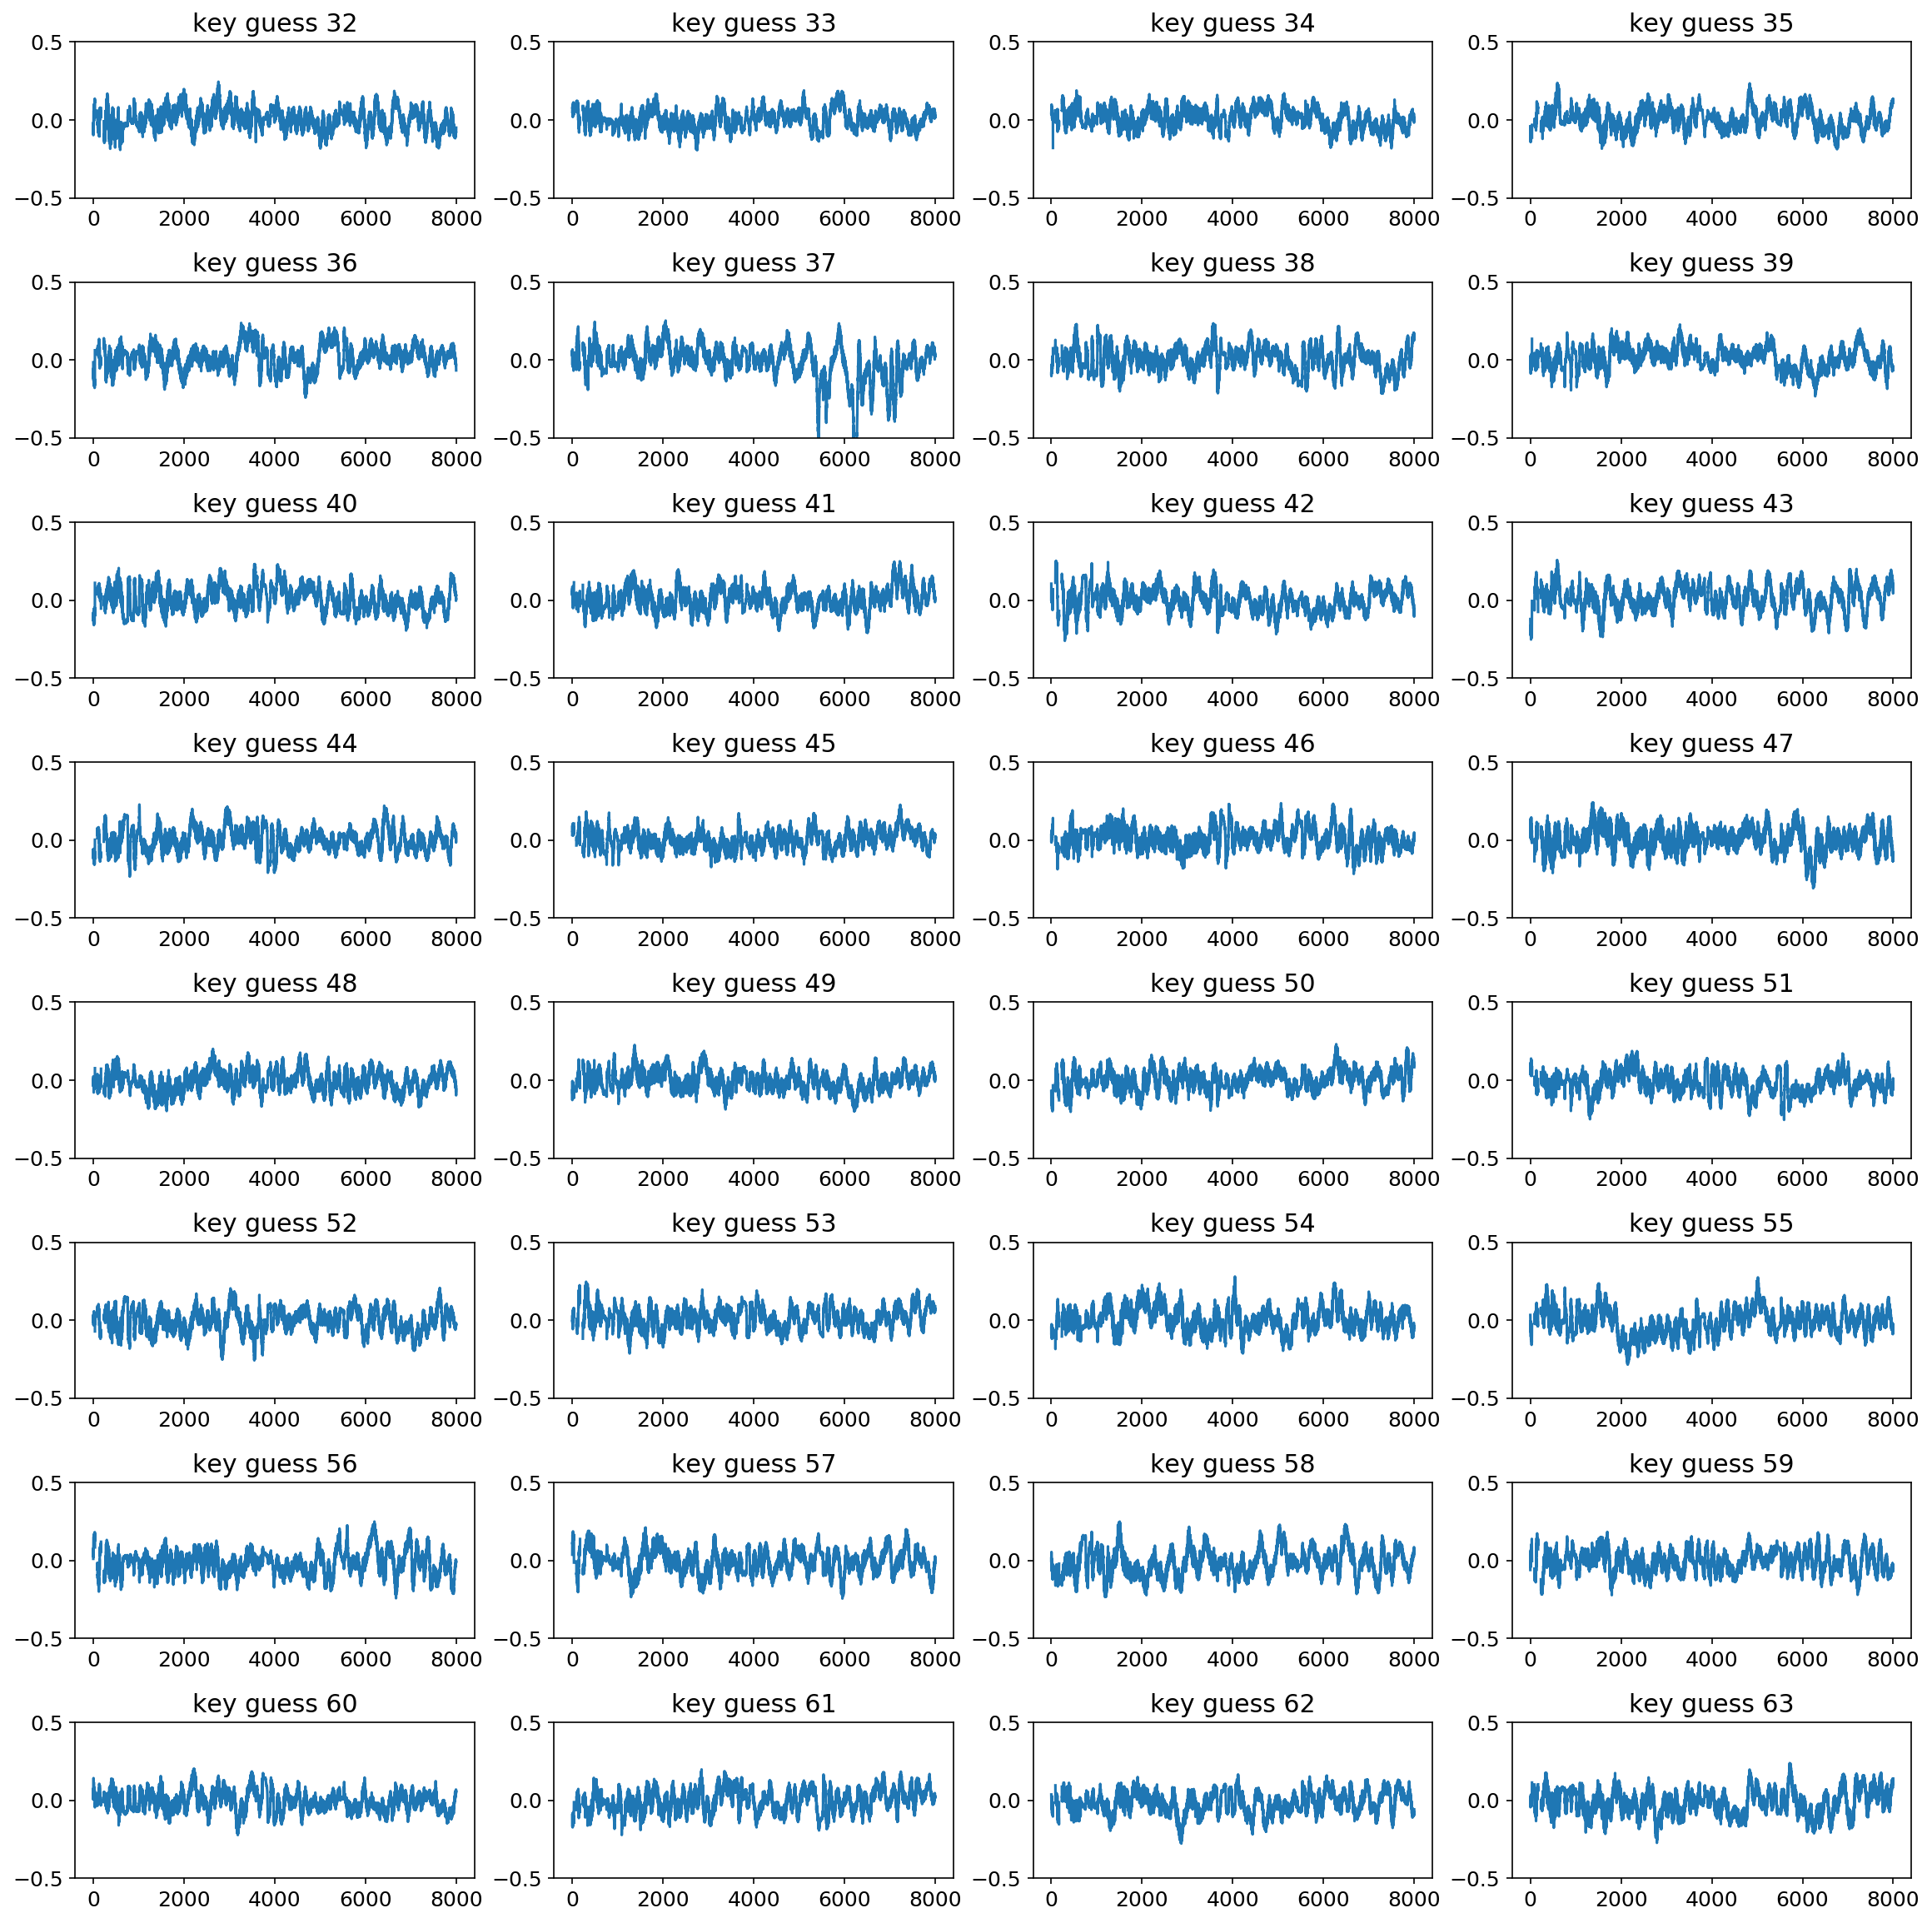

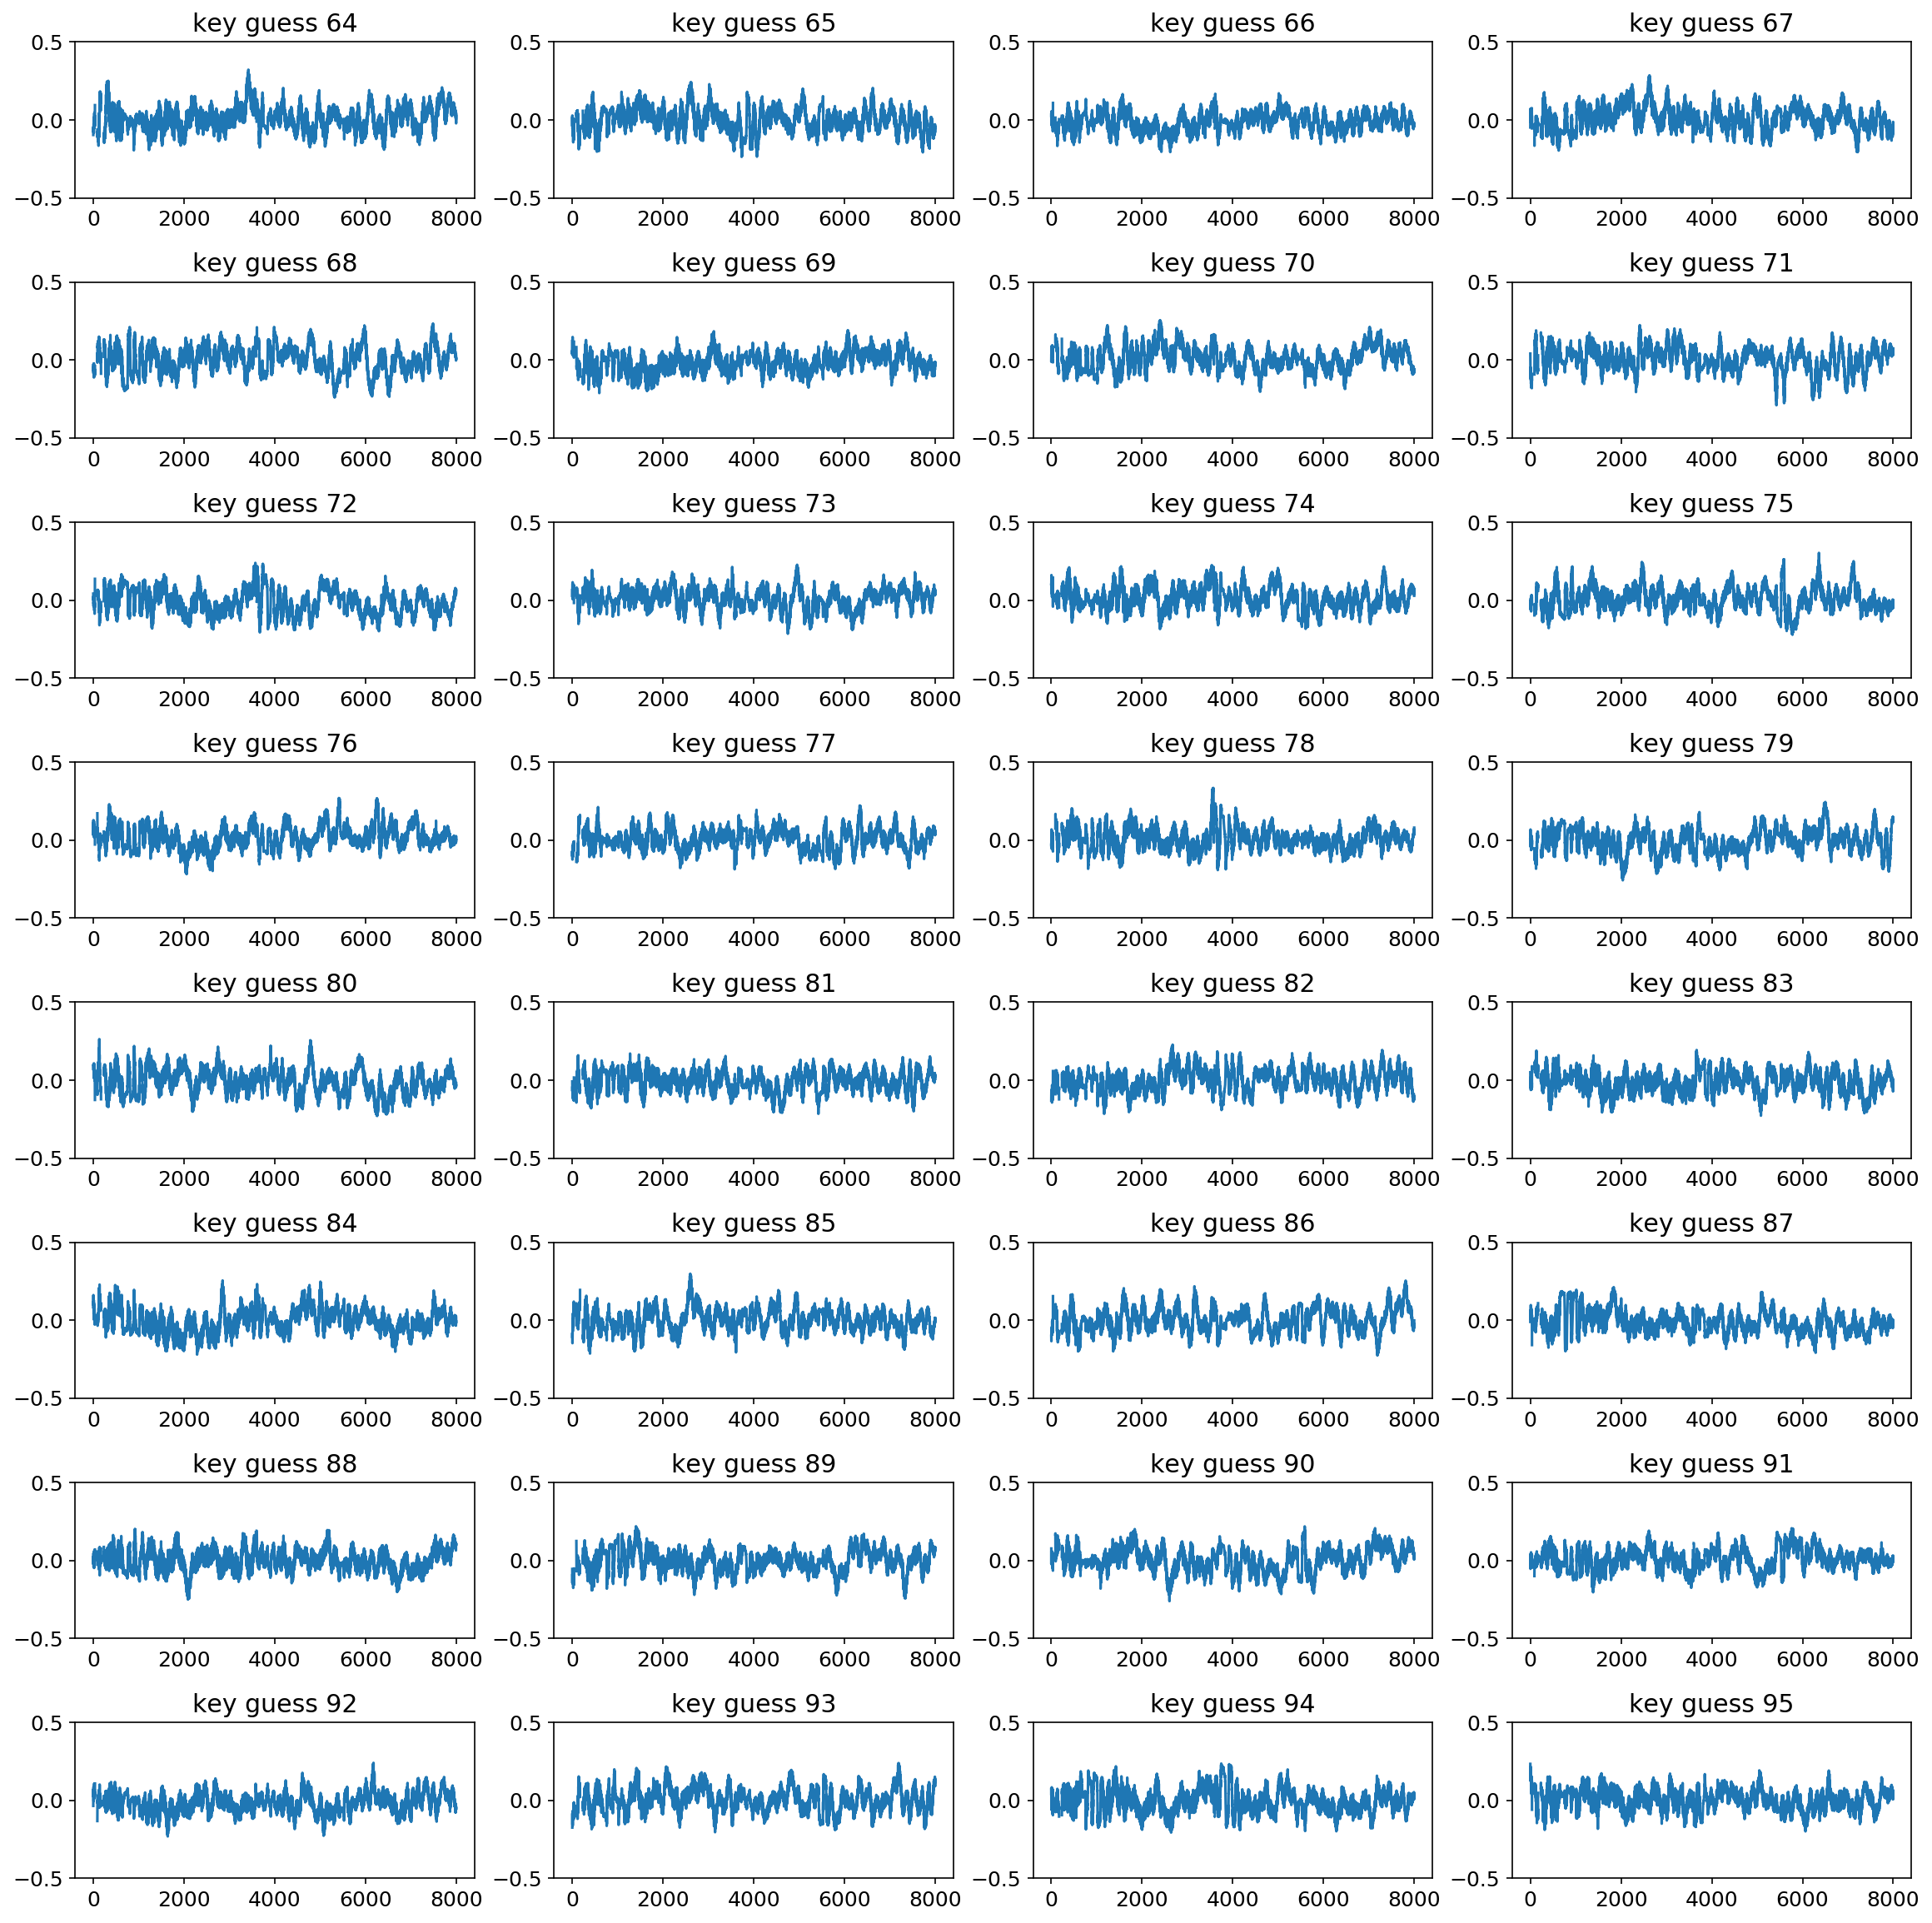

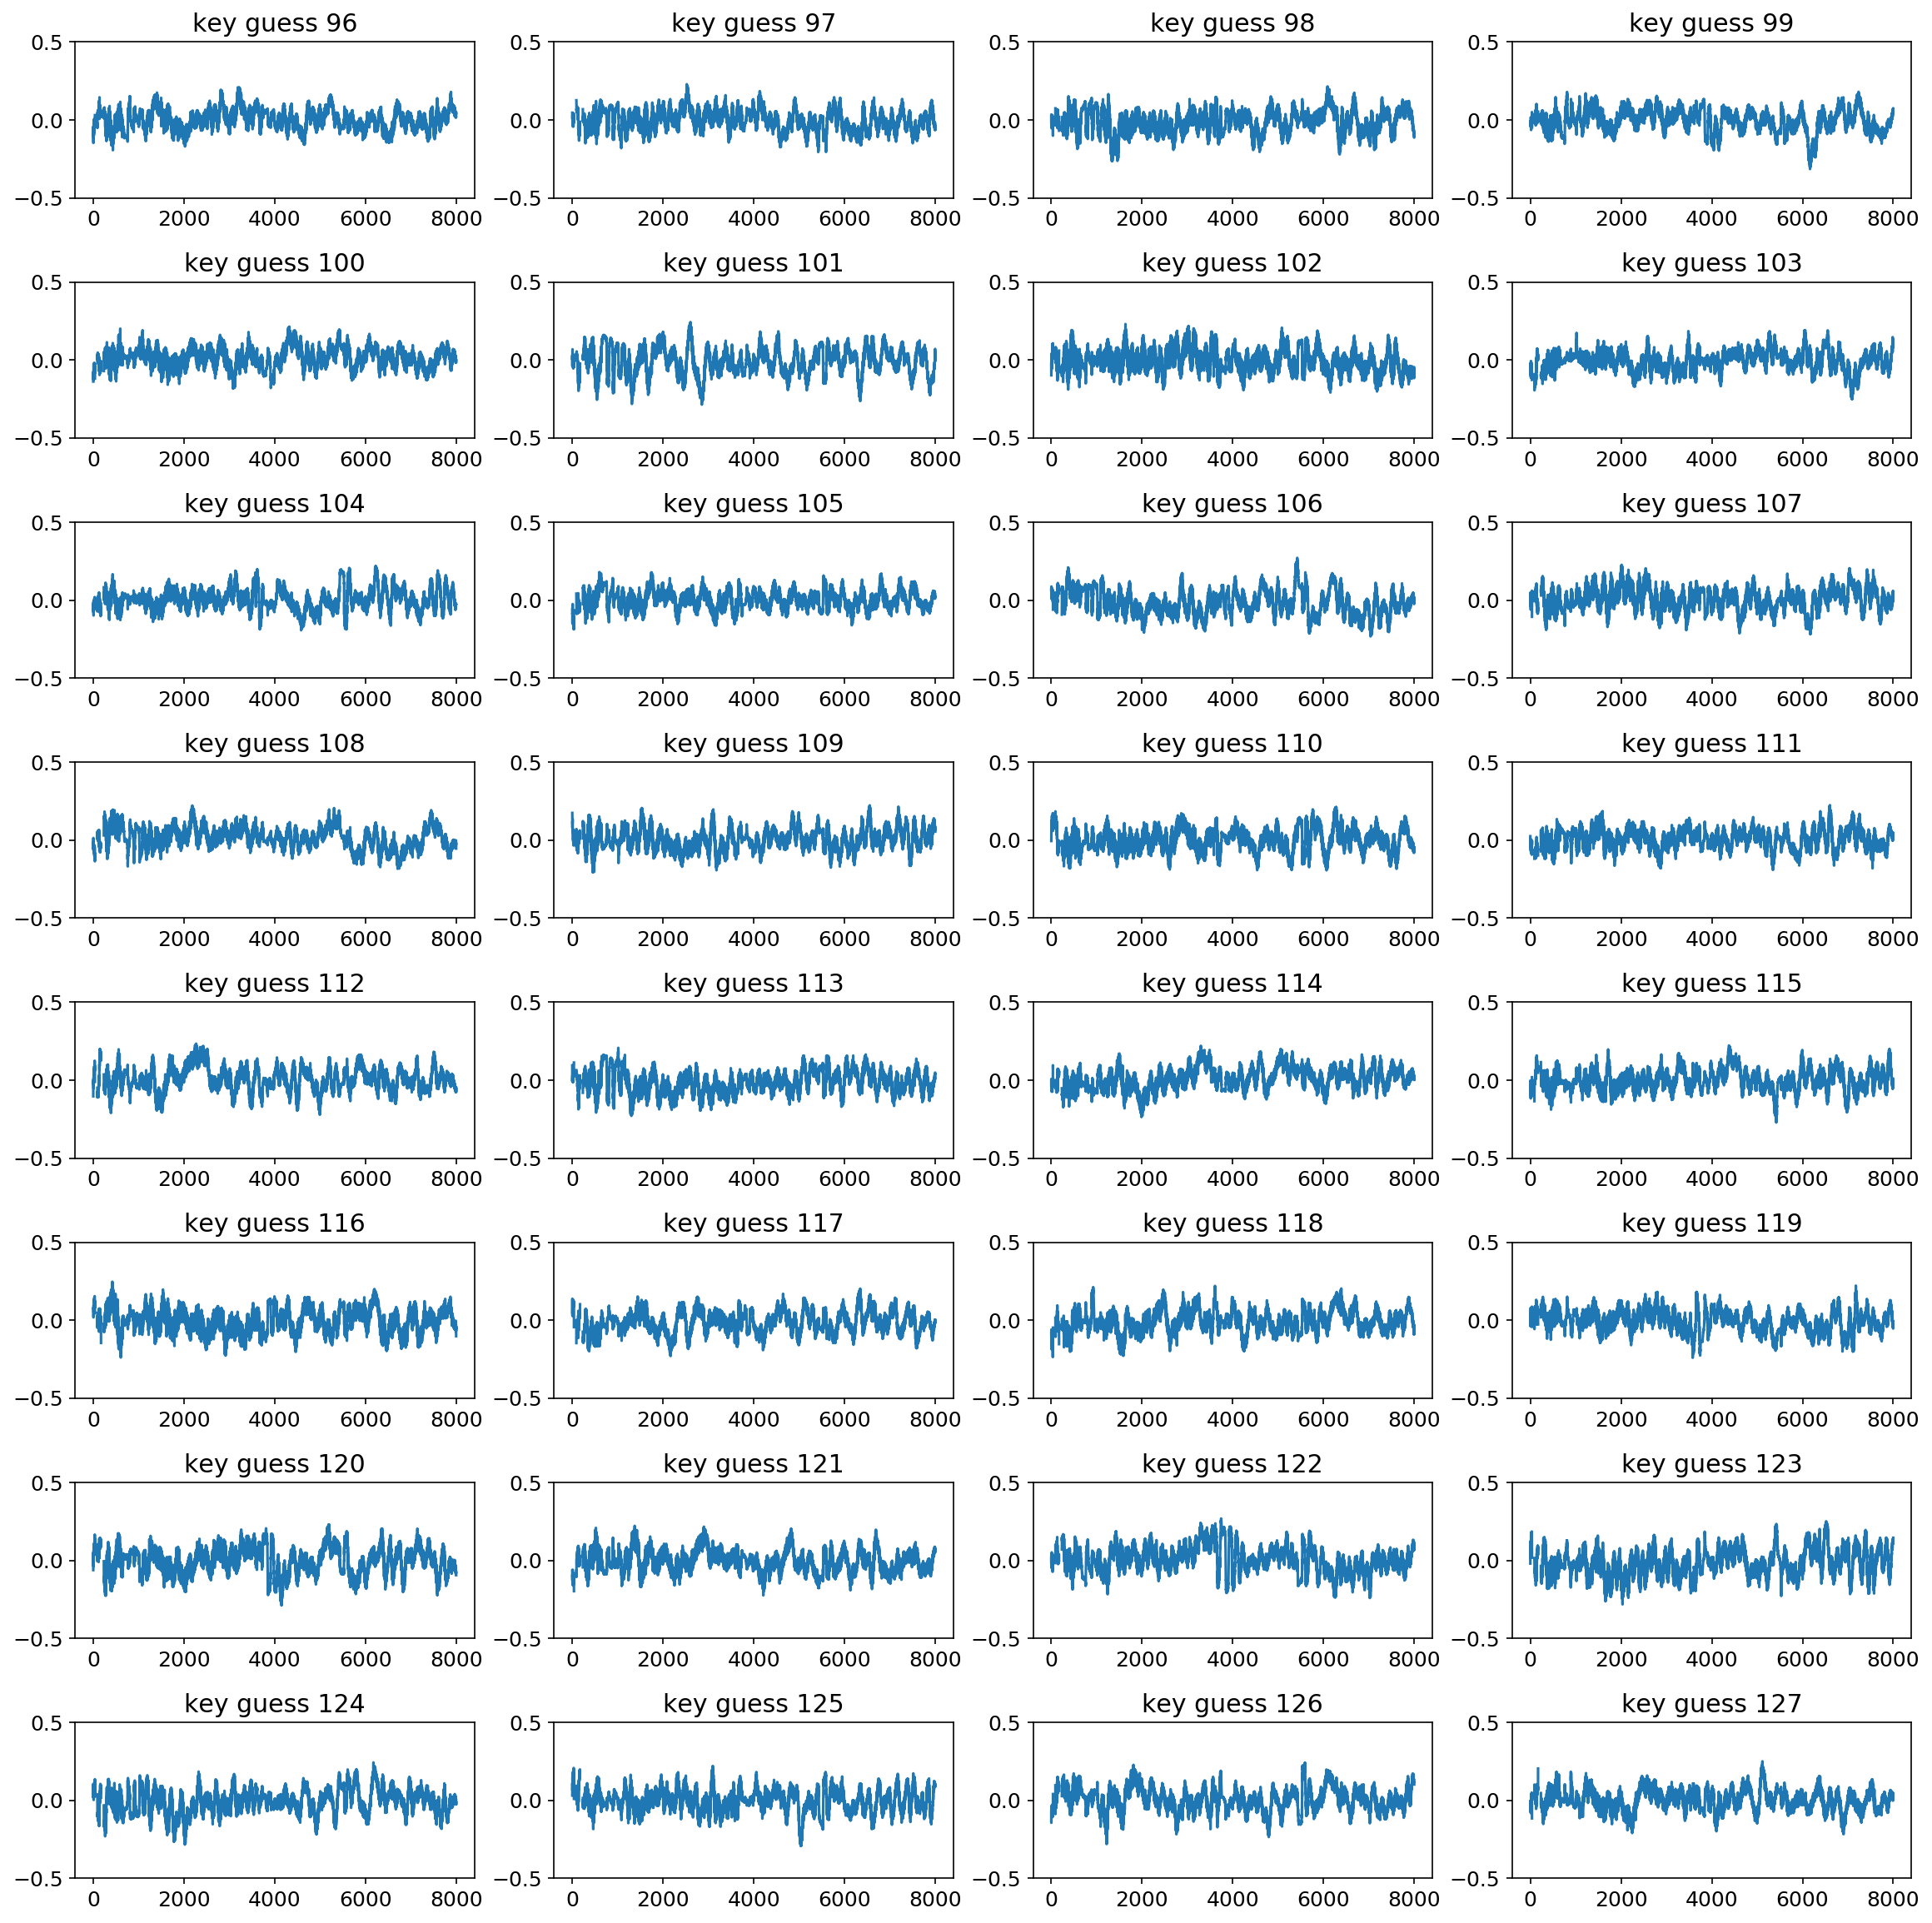

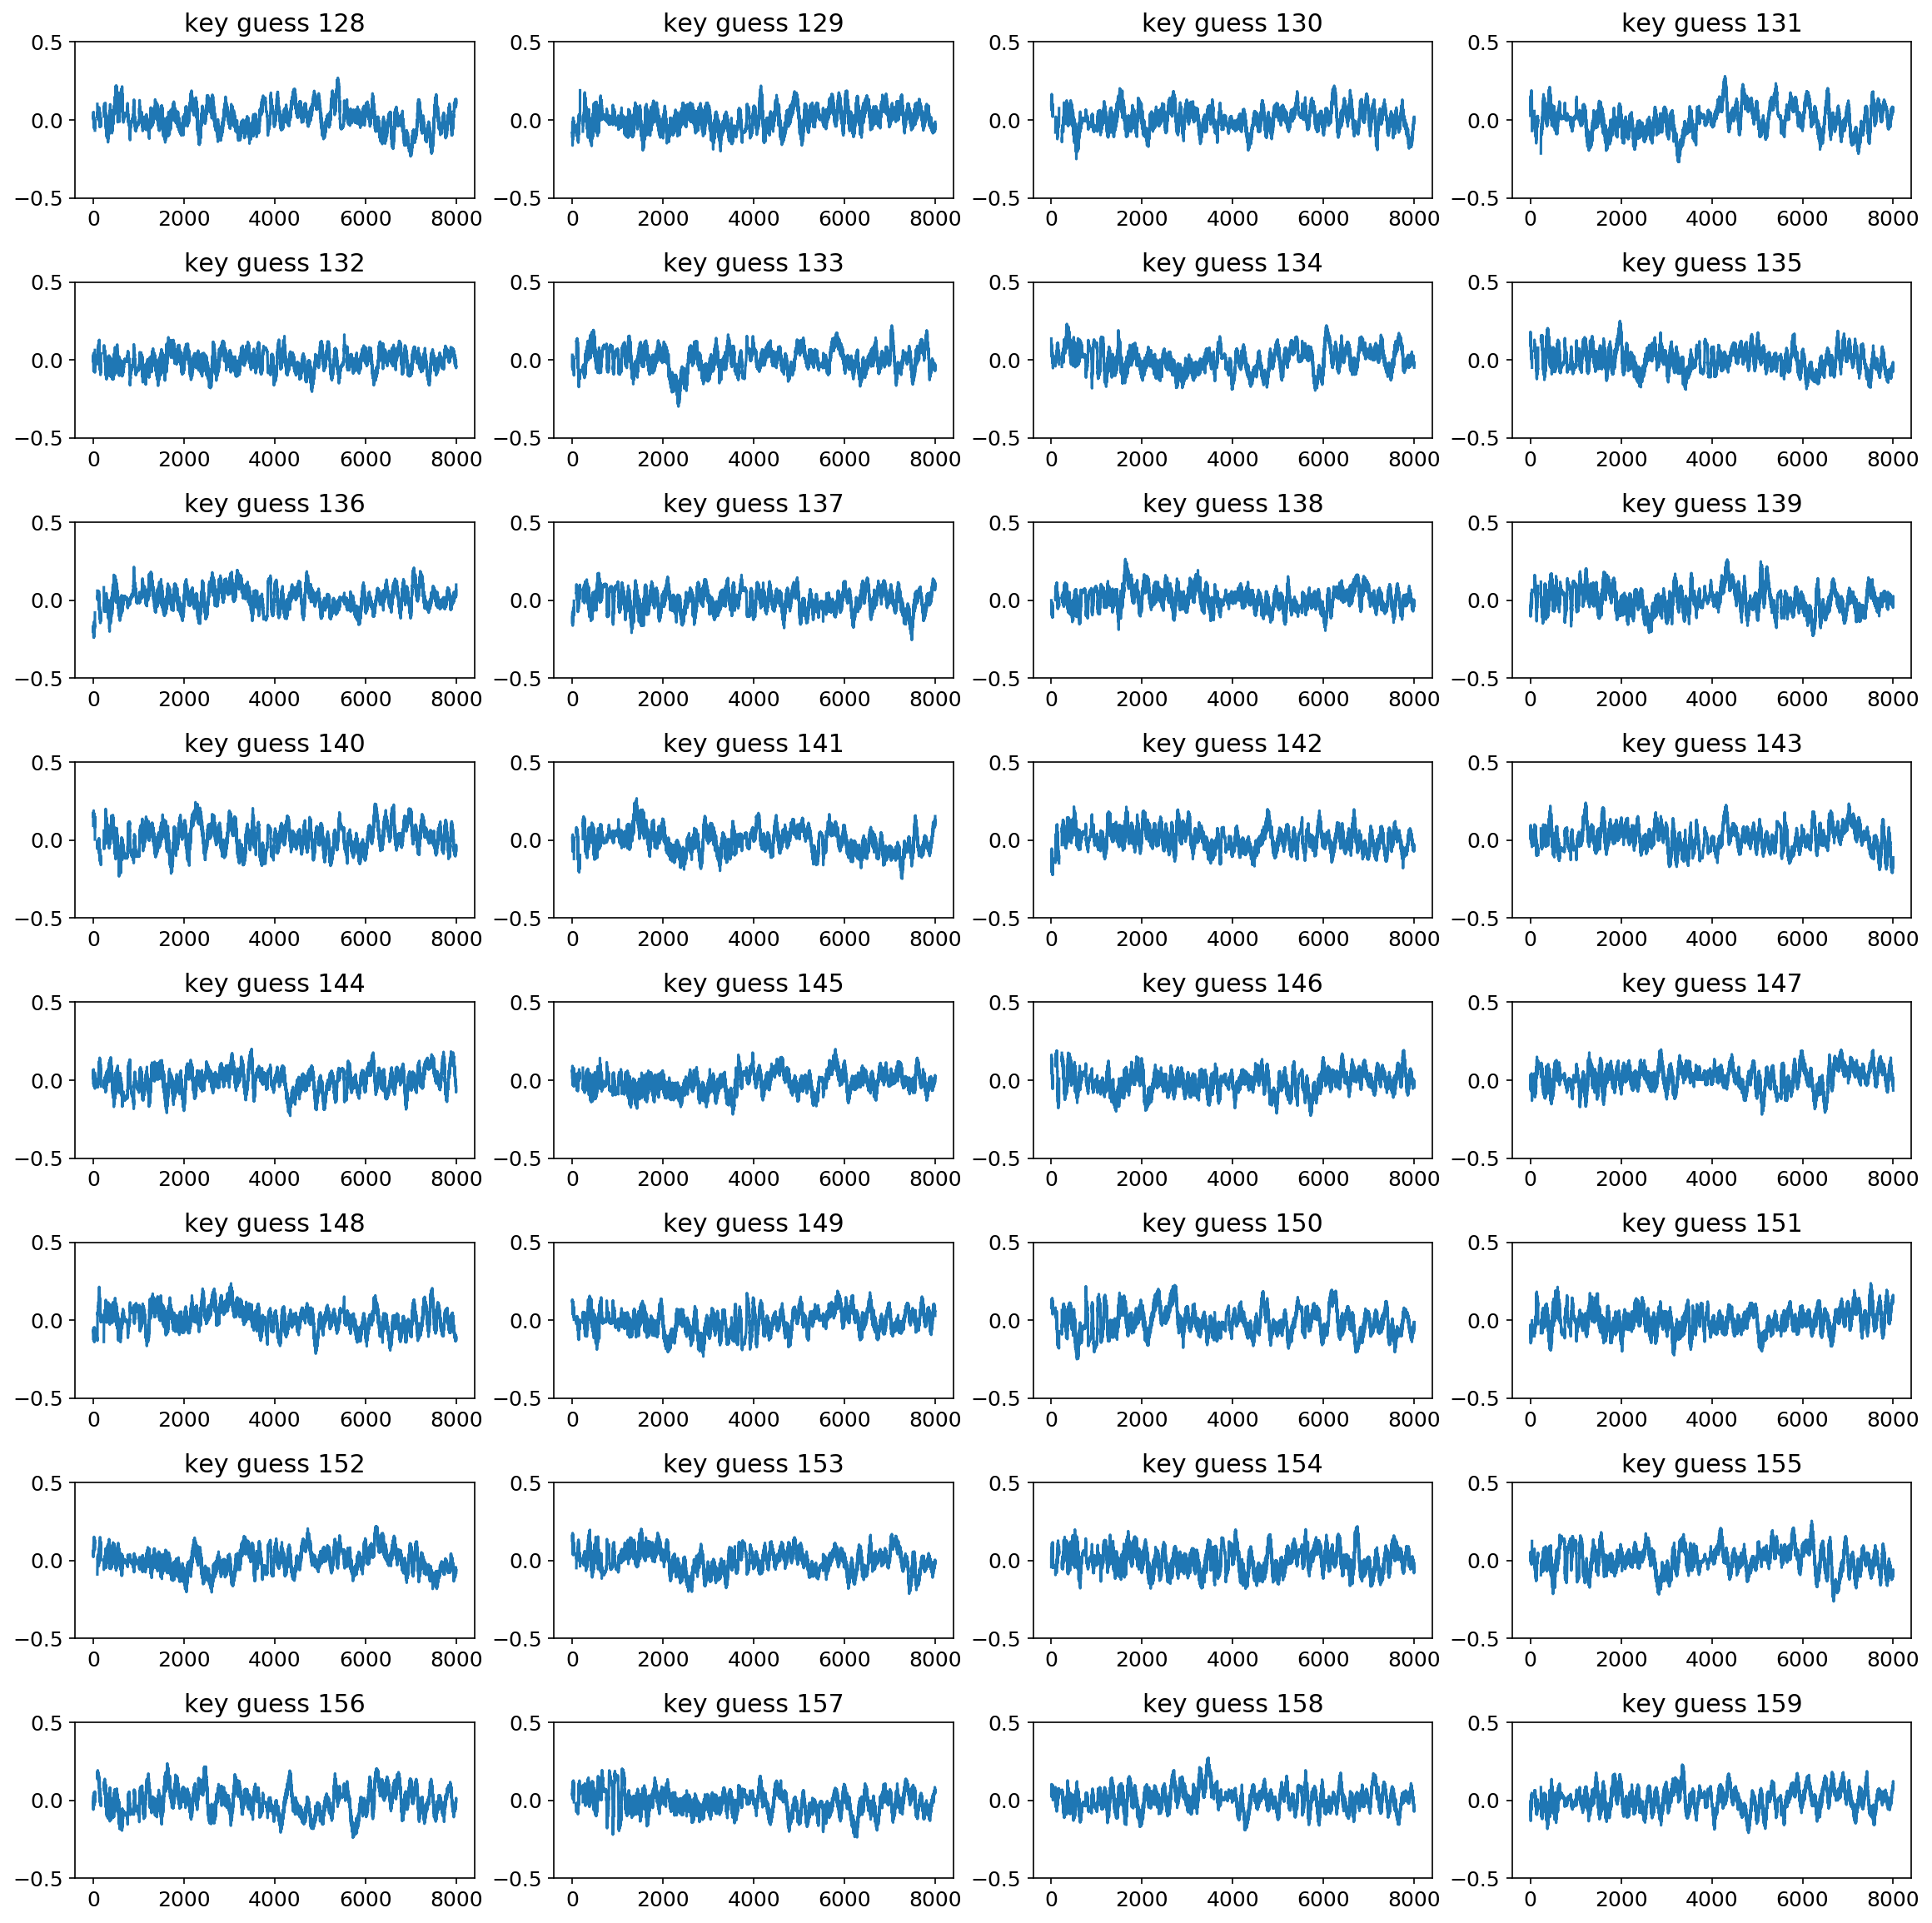

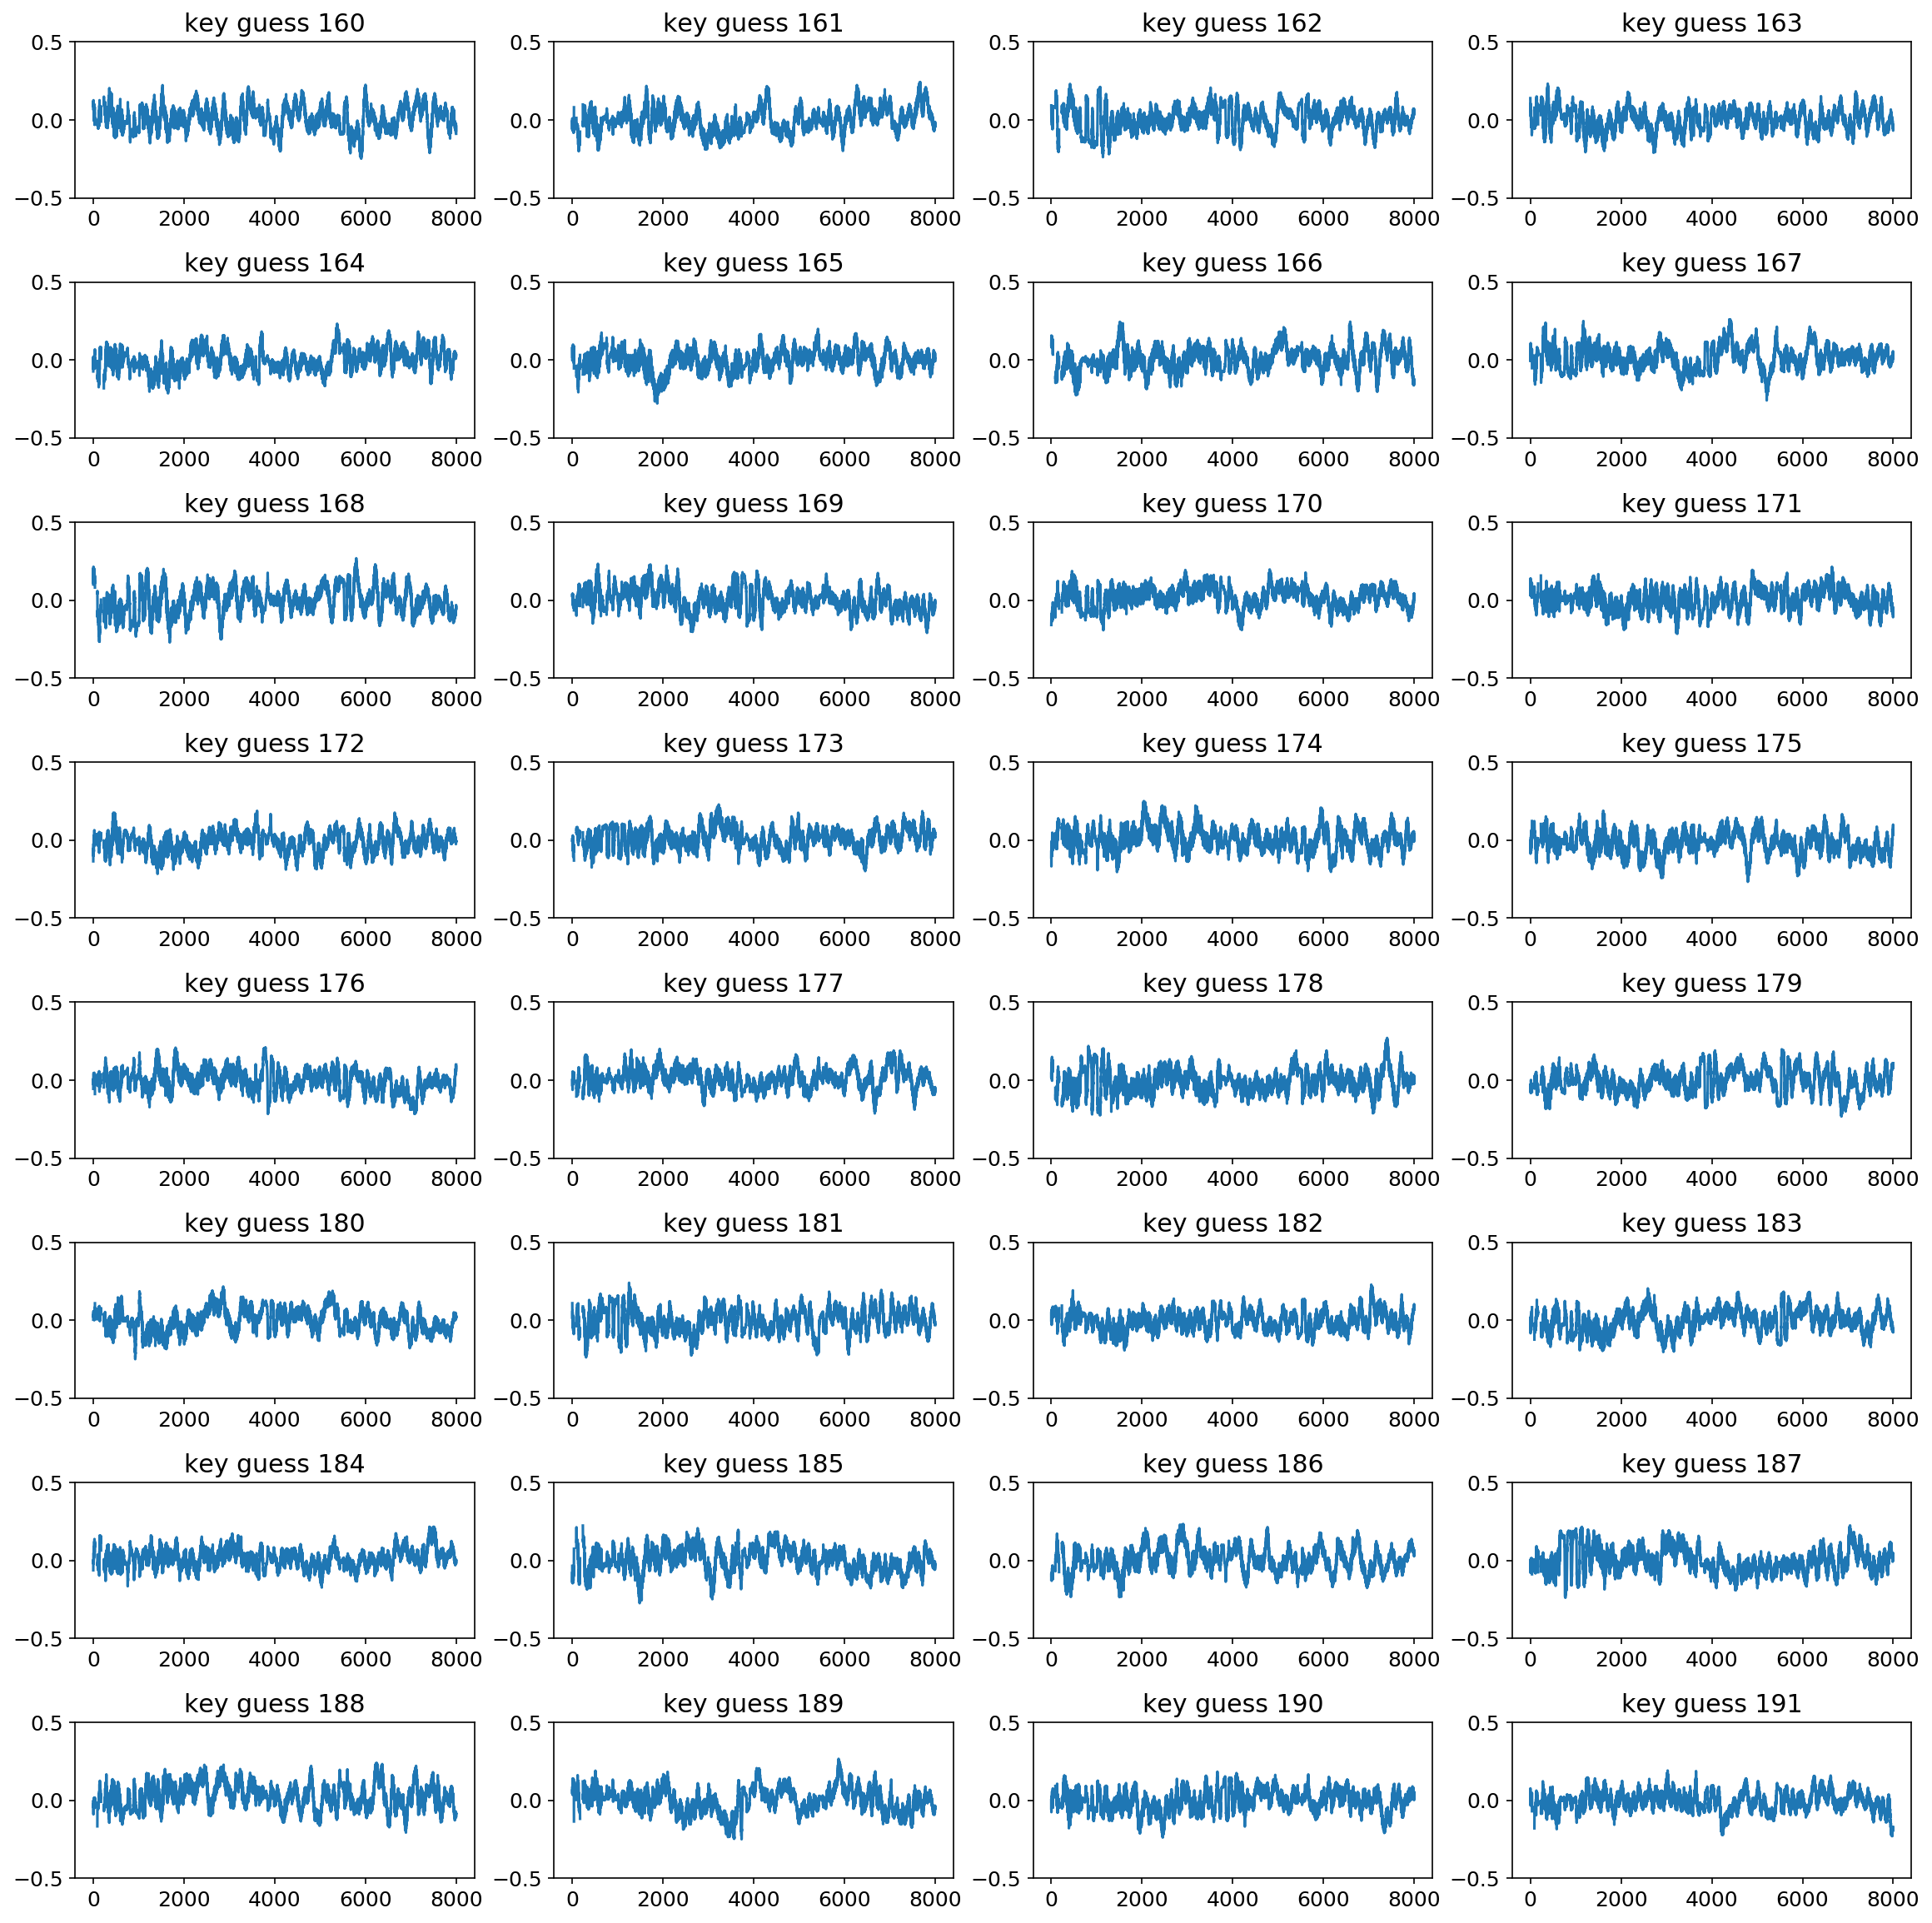

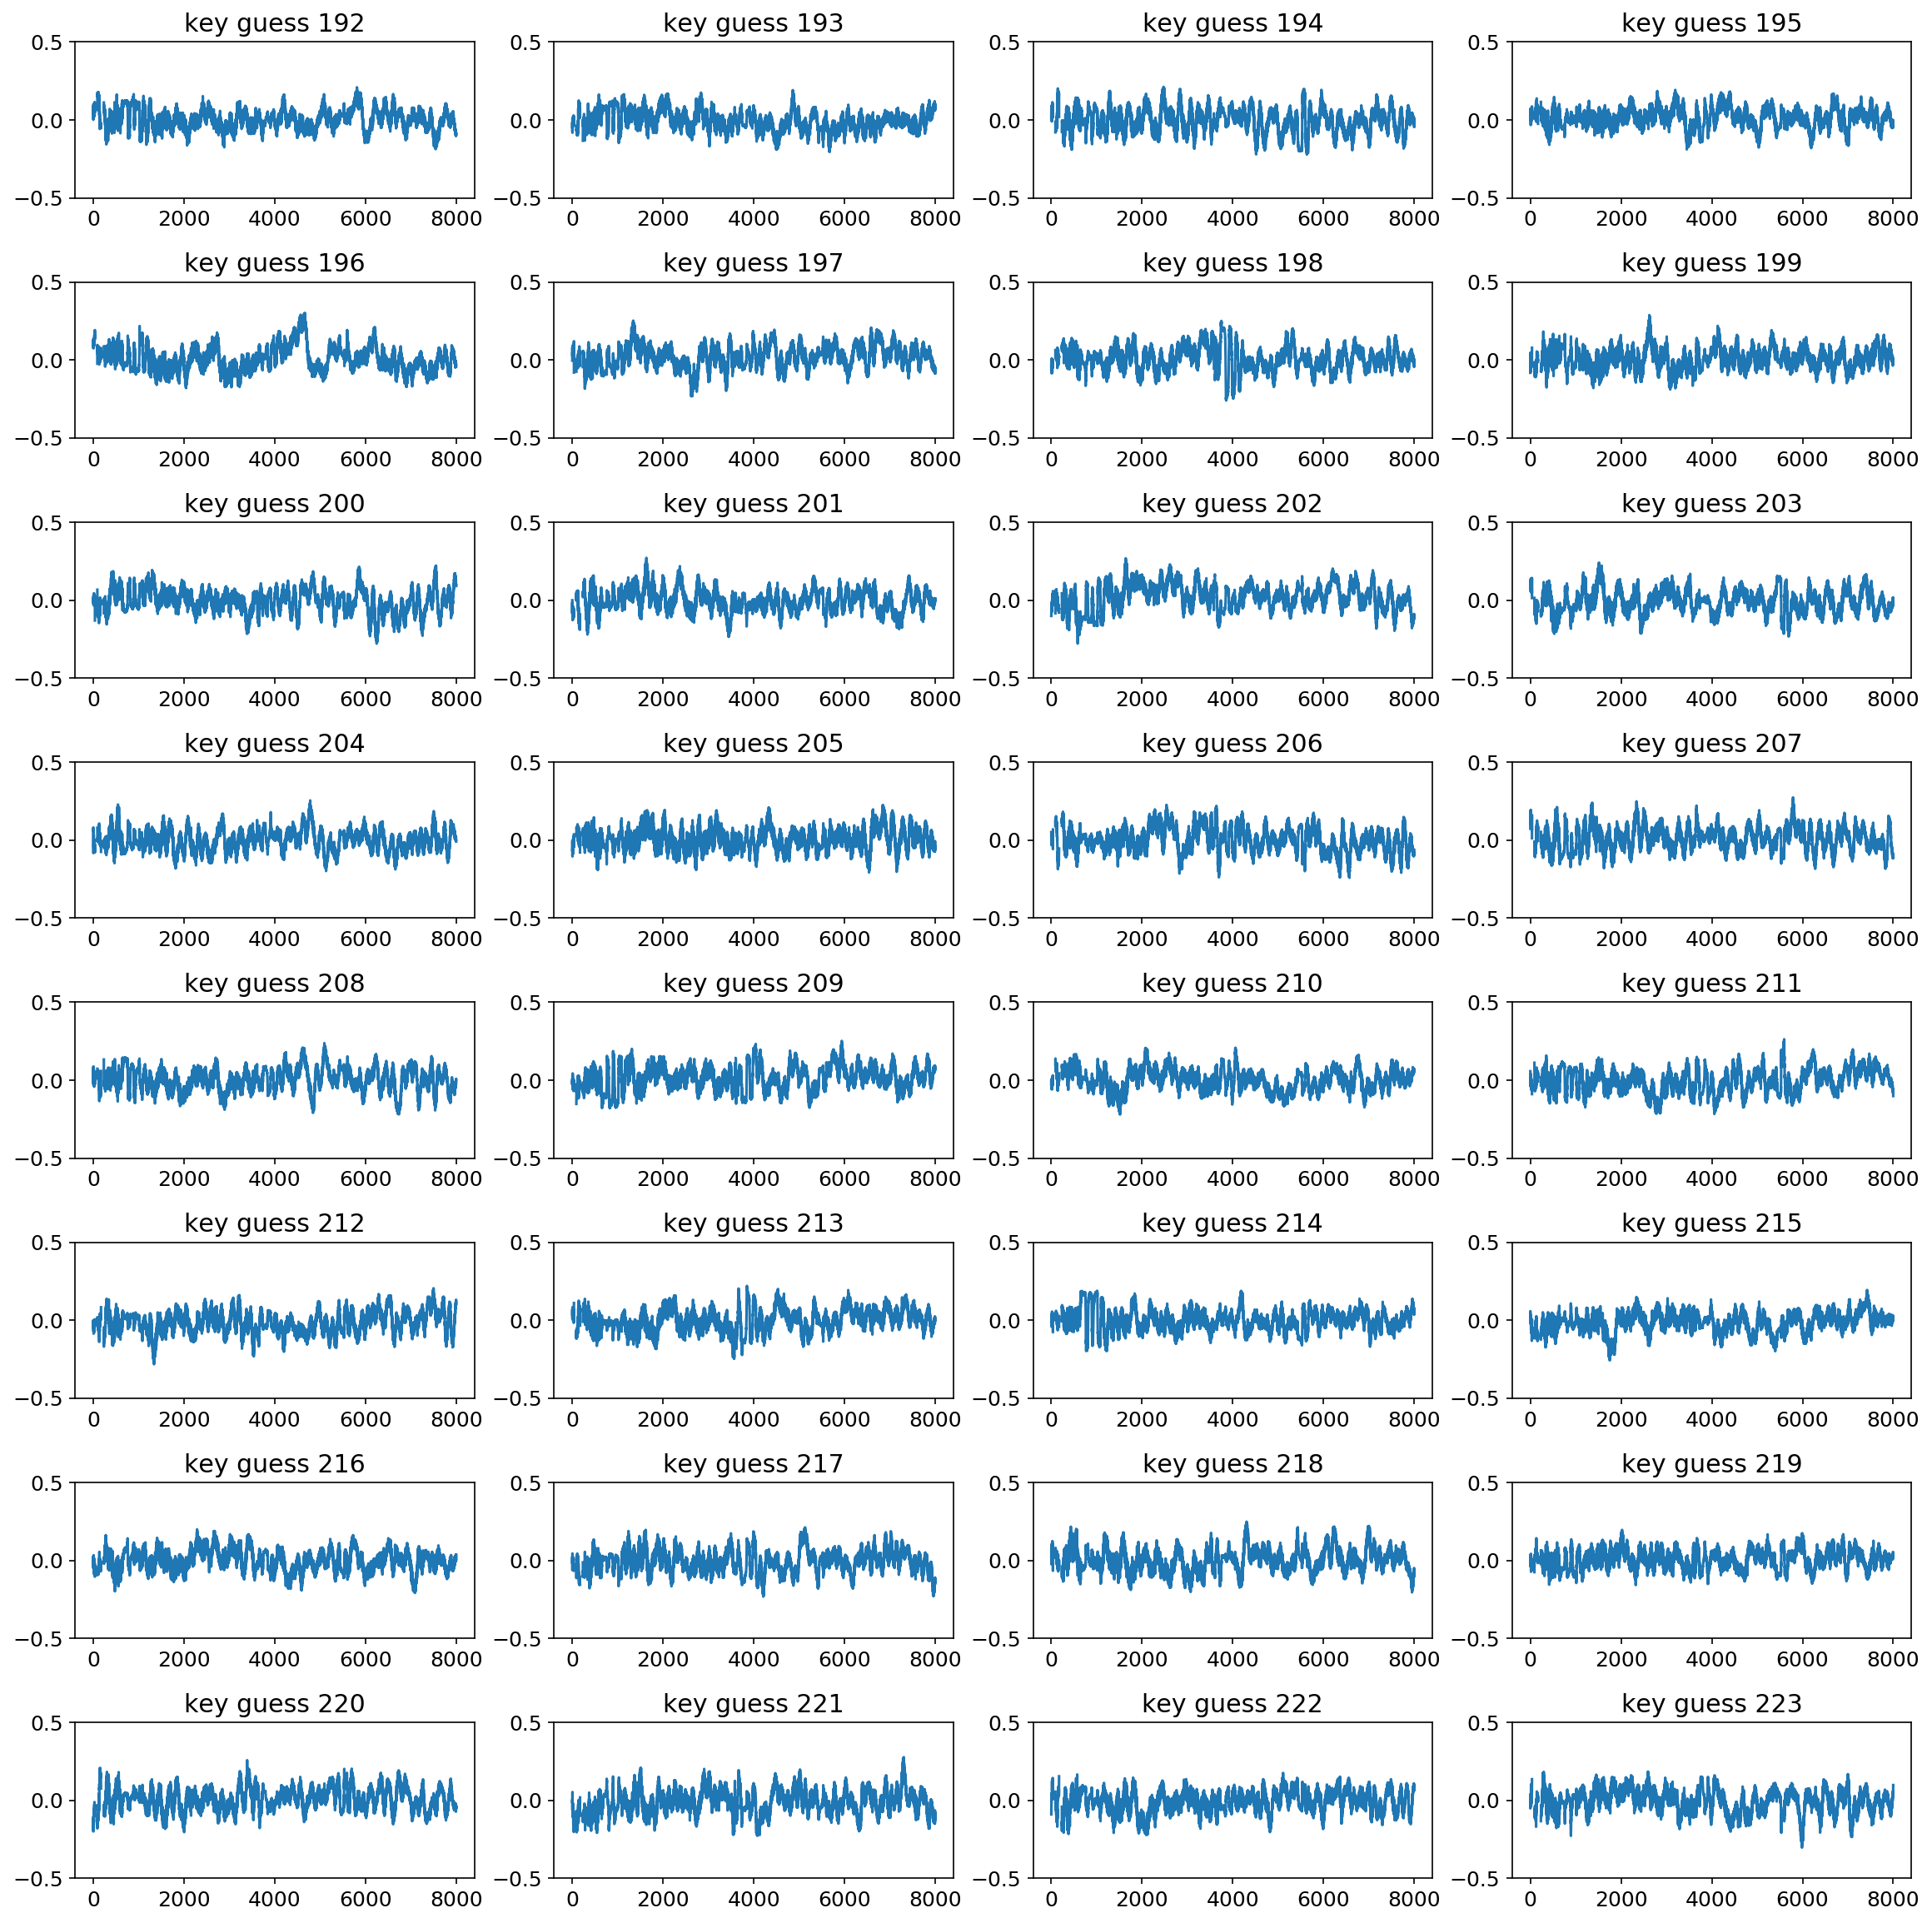

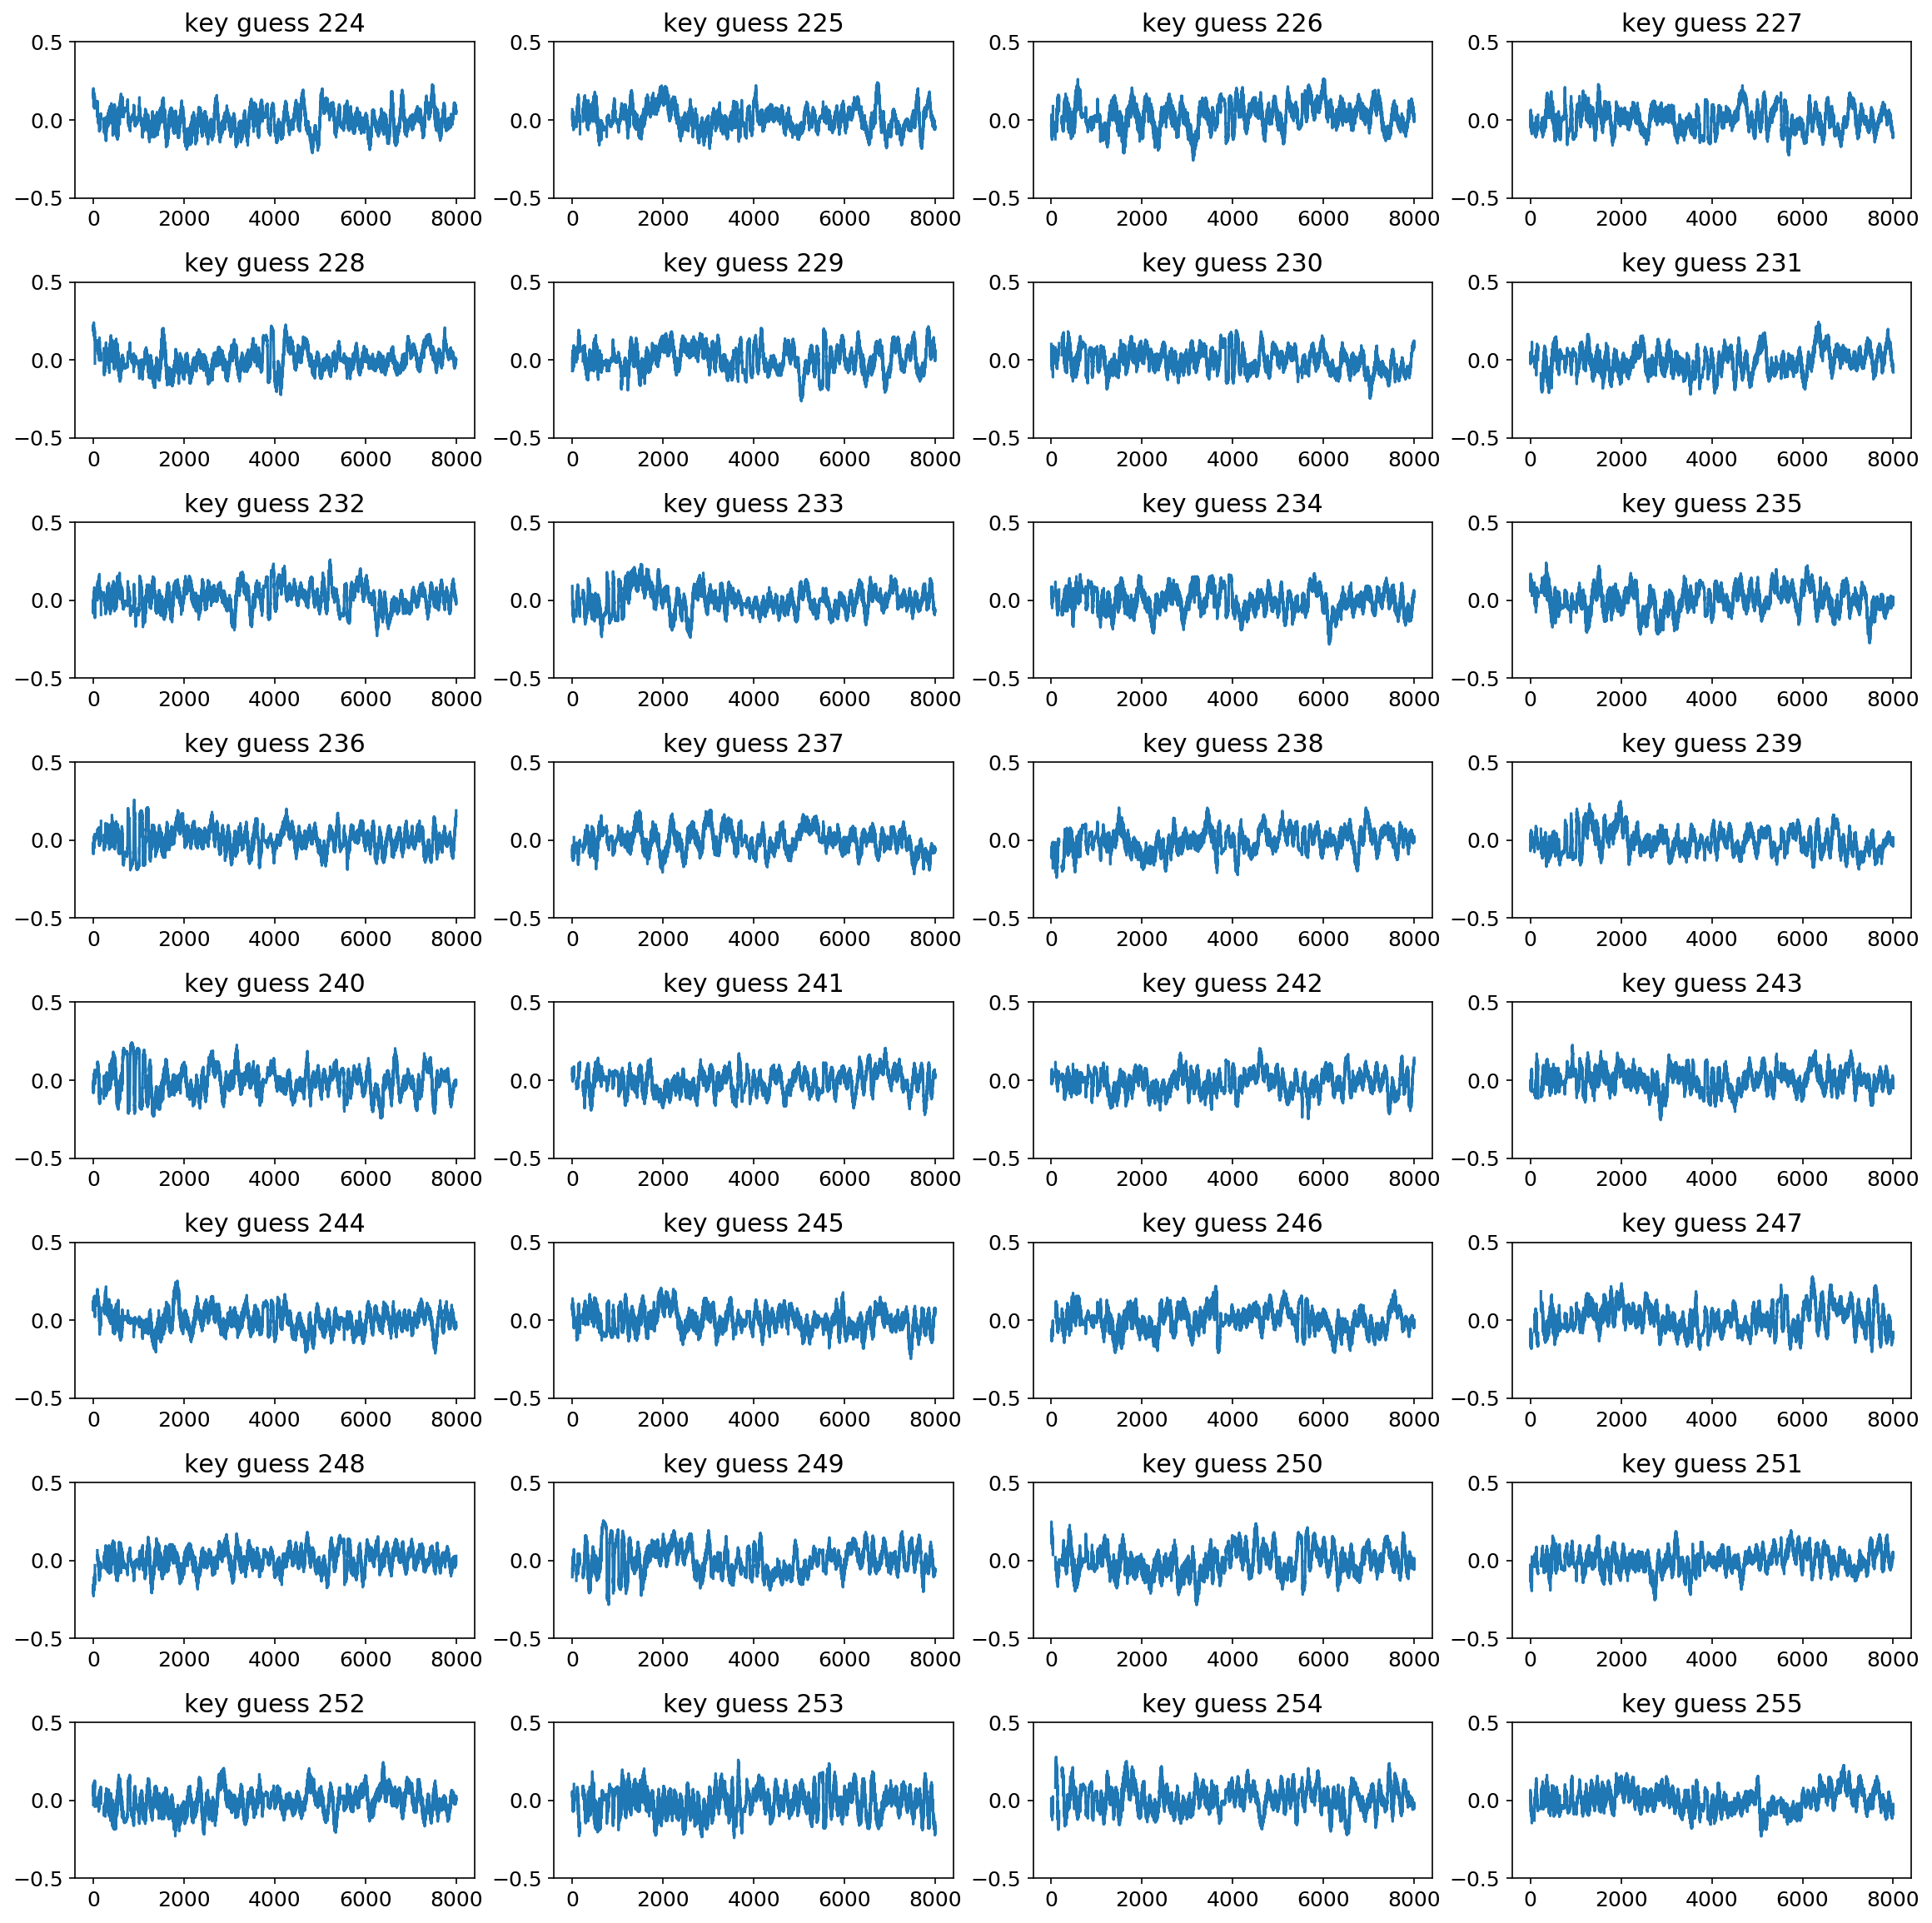

In [190]:
for j in range(8):
    fig,ax = plt.subplots(8,4)
    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.2, hspace=0.54)
    plt.rc('figure', figsize=(15, 15), dpi=150)
    plt.rc('font', size=12)
    for i in range(32):
        k = i + j * 32;
        ax[i // 4, i % 4].set_ylim(-0.5, 0.5)
        ax[i // 4, i % 4].plot(key_trace[k])
        ax[i // 4, i % 4].set_title("key guess %d" % k)
    plt.show()

In [207]:
t, s, M, C, T = traces_ld("traces.dat") 

M plaintexts load finish (1000, 16)
C ciphertexts load finish (1000, 16)
T traces samples load finish


In [220]:
numtraces = 1000

print("AES Testing...")
cipher = AES.new(guessKey, AES.MODE_ECB)
for i in range(numtraces):
    result = cipher.encrypt(M[i])
    comparison = C[i].tobytes() == result
    if not (comparison):
        print("Test Fail.")
print("Test Pass.")


AES Testing...
Test Pass.


In [204]:
a = np.array([1,2,3])
b = np.array([1,4,3])

comparison = a == b
equal_arrays = comparison.all()
print(equal_arrays)

False


In [221]:
np.shape(M)[0]

1000